This is my PyTorch implementation of the Proposed Method in the following paper:
https://www.sciencedirect.com/science/article/pii/S0893608023000680

In [9]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import pandas as pd
import torch.optim as optim

```wget -O FuelConsumption.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%202/data/FuelConsumptionCo2.csv```

In [10]:
# Load in the Dataset

df = pd.read_csv("FuelConsumption.csv")
df.head()

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2014,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,2014,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,2014,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,2014,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,2014,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


## Linear Regression Example

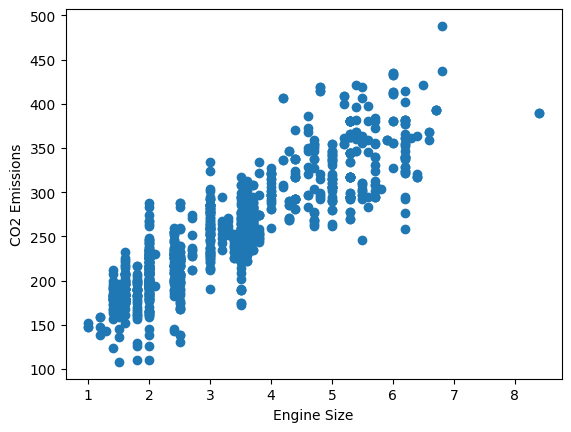

In [11]:
# For the Purpose of the Linear Regression Task, we will attempt to model the relationship between Engine Size and CO2 Emissions

plt.scatter(df['ENGINESIZE'], df['CO2EMISSIONS'])
plt.xlabel("Engine Size")
plt.ylabel("CO2 Emissions")
plt.show()

As this method is designed to work with Imprecise Data, we will convert the precise data into converting the Emissions values into intervals by adding and subtracting 10%.

   ENGINESIZE  CO2EMISSIONS  CO2_lower  CO2_upper
0         2.0           196      176.4      215.6
1         2.4           221      198.9      243.1
2         1.5           136      122.4      149.6
3         3.5           255      229.5      280.5
4         3.5           244      219.6      268.4


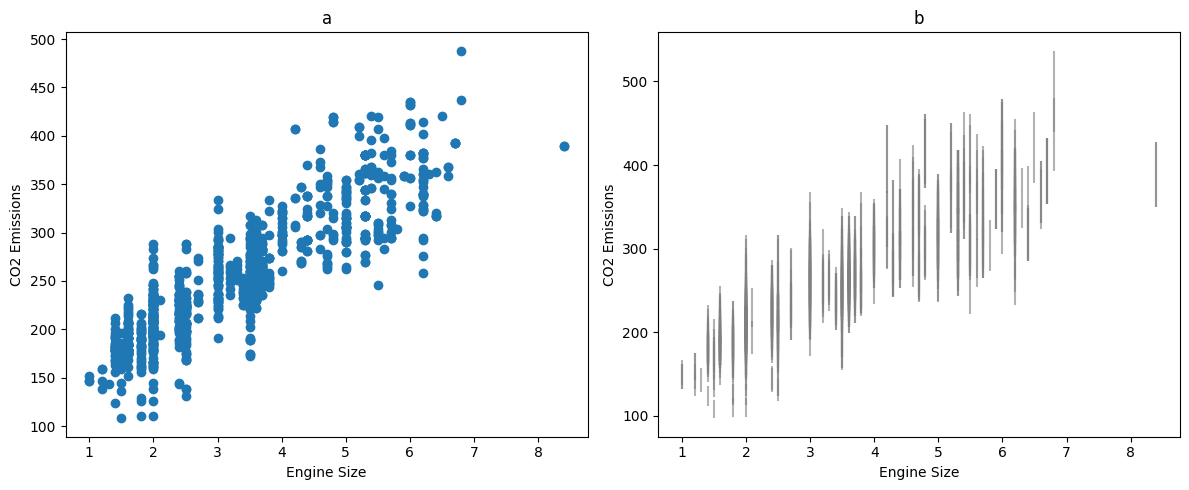

In [12]:
X = df[['ENGINESIZE']].values.ravel()
y = df[['CO2EMISSIONS']].values.ravel()

# 2% intervals
#y_lower = y * 0.98
#y_upper = y * 1.02

# 5% intervals
#y_lower = y * 0.95
#y_upper = y * 1.05

# 10% intervals
y_lower = y * 0.90
y_upper = y * 1.10

df["CO2_lower"] = y_lower
df["CO2_upper"] = y_upper

print(df[["ENGINESIZE", "CO2EMISSIONS", "CO2_lower", "CO2_upper"]].head())

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Panel a: scatter plot
axes[0].scatter(df['ENGINESIZE'], df['CO2EMISSIONS'])
axes[0].set_xlabel("Engine Size")
axes[0].set_ylabel("CO2 Emissions")
axes[0].set_title("a")

# Panel b: intervals
axes[1].vlines(X, y_lower, y_upper, color="gray", alpha=0.6)
axes[1].set_xlabel("Engine Size")
axes[1].set_ylabel("CO2 Emissions")
axes[1].set_title("b")

plt.tight_layout()
plt.show()


Now, time to move onto the actual model, we will first convert our values into PyTorch tensors so they are compatible with the PyTorch Neural Network.

In [13]:
X_tensor = torch.tensor(X, dtype=torch.float32).view(-1, 1)
y_lower_tensor = torch.tensor(y_lower, dtype=torch.float32).view(-1, 1)
y_upper_tensor = torch.tensor(y_upper, dtype=torch.float32).view(-1, 1)

### Model

For the model:

h = XW + b

we let the **weights** and **biases** be uncertain. Instead of treating them as single point values, they are represented as **intervals**:

W = W_mid ± W_rad,   b = b_mid ± b_rad

where:  

- `W_mid`, `b_mid` = the **central (nominal)** values of the parameters  
- `W_rad`, `b_rad` = the **radius of uncertainty** (how much each parameter can vary)  

Using these, the model prediction also becomes an **interval**:

h_mid = X W_mid + b_mid  
h_rad = |X| W_rad + b_rad  

so that the final prediction is:

h = [h_mid - h_rad,  h_mid + h_rad]

This formulation guarantees that the true output lies within the predicted bounds, while still allowing training with standard optimisation tools (e.g., gradient descent with momentum) by propagating both the lower and upper bounds through the network.

---

## Loss Function

We use the interval mean squared error (IMSE) loss defined by the authors:

L_IMSE = (1 / 2N) || h - [Y] ||²

For implementation purposes, this is written explicitly as:

L_IMSE = (1 / 2N) Σ ((h_i^- - y_i^-)² + (h_i^+ - y_i^+)²)

where:  
- `h_i^-` and `h_i^+` are the predicted lower and upper bounds  
- `y_i^-` and `y_i^+` are the ground-truth lower and upper bounds  
- N is the number of samples

In [14]:
class IntervalMSELoss(nn.Module):
    def forward(self, pred_lower, pred_upper, true_lower, true_upper):
        loss = ((pred_lower - true_lower)**2 + (pred_upper - true_upper)**2).mean() / 2
        return loss

class IntervalLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.W_mid = nn.Parameter(torch.randn(in_features, out_features))
        self.W_rad = nn.Parameter(torch.abs(torch.randn(in_features, out_features)))
        self.b_mid = nn.Parameter(torch.zeros(out_features))
        self.b_rad = nn.Parameter(torch.abs(torch.randn(out_features)))

    def forward(self, x):
        h_mid = x @ self.W_mid + self.b_mid
        h_rad = torch.abs(x) @ self.W_rad + self.b_rad
        h_lower = h_mid - h_rad
        h_upper = h_mid + h_rad
        return h_lower, h_upper

In [ ]:
# Model, loss, optimizer
model = IntervalLinear(in_features=1, out_features=1)
criterion = IntervalMSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)

# Training
epochs = 5000
for epoch in range(epochs):
    pred_lower, pred_upper = model(X_tensor)
    loss = criterion(pred_lower, pred_upper, y_lower_tensor, y_upper_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 20/300, Loss: 2853.0020
Epoch 40/300, Loss: 3293.8364
Epoch 60/300, Loss: 2659.5044
Epoch 80/300, Loss: 2424.6675
Epoch 100/300, Loss: 2339.6753
Epoch 120/300, Loss: 2261.7214
Epoch 140/300, Loss: 2188.1526
Epoch 160/300, Loss: 2118.9480
Epoch 180/300, Loss: 2053.6433
Epoch 200/300, Loss: 1992.0040
Epoch 220/300, Loss: 1933.8267
Epoch 240/300, Loss: 1878.9154
Epoch 260/300, Loss: 1827.0868
Epoch 280/300, Loss: 1778.1682
Epoch 300/300, Loss: 1731.9958


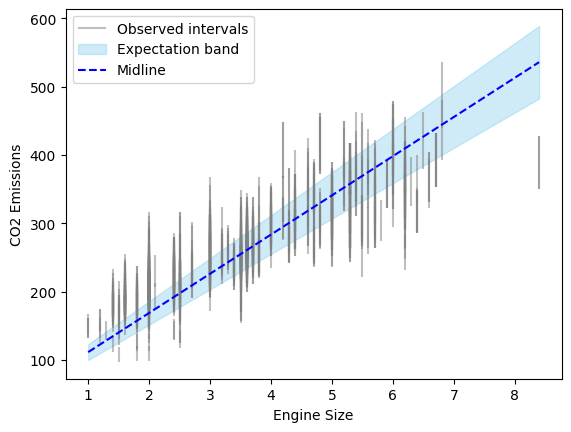

In [16]:
x_vals = torch.linspace(X_tensor.min(), X_tensor.max(), 200).unsqueeze(1)
pred_lower, pred_upper = model(x_vals)

x_vals = x_vals.detach().numpy().flatten()
lower_vals = pred_lower.detach().numpy().flatten()
upper_vals = pred_upper.detach().numpy().flatten()

# Sort by x for plotting
idx = np.argsort(x_vals)
x_sorted = x_vals[idx]
lower_sorted = lower_vals[idx]
upper_sorted = upper_vals[idx]

# Plot data intervals (as vertical lines)
plt.vlines(X_tensor.numpy().flatten(),
           y_lower_tensor.numpy().flatten(),
           y_upper_tensor.numpy().flatten(),
           color="gray", alpha=0.5, label="Observed intervals")

# Plot prediction band
plt.fill_between(x_sorted, lower_sorted, upper_sorted,
                 color="skyblue", alpha=0.4, label="Expectation band")
plt.plot(x_sorted, (lower_sorted+upper_sorted)/2,
         color="blue", linestyle="--", label="Midline")

plt.xlabel("Engine Size")
plt.ylabel("CO2 Emissions")
plt.legend()
plt.show()
